# Load libraries & parameters

In [1]:
%matplotlib inline
import itertools as it
from sklearn.impute import SimpleImputer, KNNImputer
import numpy as np 
import pandas as pd 
import math
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.utils import to_categorical
from keras.utils import np_utils
import seaborn as sns
import scipy.cluster.hierarchy as spc
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from jmetal.algorithm.singleobjective.genetic_algorithm import GeneticAlgorithm
from jmetal.operator import BinaryTournamentSelection
from jmetal.operator.crossover import PMXCrossover
from jmetal.operator.mutation import PermutationSwapMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.observer import PrintObjectivesObserver
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support, recall_score
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
import datetime
import pickle
from pyod.models.auto_encoder import AutoEncoder
from sklearn.metrics import confusion_matrix
import dill
from sklearn import preprocessing

# parameter
load_saved_data = True
null_percentage = 0.1
test_ratio = 0.2
random_state = 1

epochs = 200
hid_neu = [32, 18, 18, 32]
k_best = 120
m_subsets = 3
assert k_best % m_subsets == 0
n_features = int(k_best/m_subsets)

Using TensorFlow backend.


# Feature correlation selection

In [2]:
from jmetal.core.problem import PermutationProblem
from jmetal.core.solution import PermutationSolution
import random

# Feature correlation selection
class FCS(PermutationProblem):

    def __init__(self, correlation, variables, subsets):
        super(FCS, self).__init__()

        self.correlation = correlation
        self.subsets = subsets
        self.n_features = int(variables/subsets)
        
        # Minimization to find most independent between variable 
        self.obj_directions = [self.MINIMIZE]
        self.number_of_variables = variables
        self.number_of_objectives = 1
        self.number_of_constraints = 0

    def evaluate(self, solution: PermutationSolution) -> PermutationSolution:
        fitness = 0

        for i in range(self.subsets):

          end = self.n_features*(i+1)
          start = end - self.n_features

          comb = list(it.combinations(solution.variables[start:end-1], 2))

          for j in comb:
              fitness += self.correlation[j[0]][j[1]]

          solution.objectives[0] = fitness

        return solution

    def create_solution(self) -> PermutationSolution:
        new_solution = PermutationSolution(number_of_variables=self.number_of_variables,
                                           number_of_objectives=self.number_of_objectives)
        new_solution.variables = random.sample(range(self.number_of_variables), k=self.number_of_variables)
        return new_solution
    
    def get_name(self):
        return 'Feature correlation selection'

# Load dataset

In [3]:
if not load_saved_data:
    #  reading the data
    data = pd.read_csv('uci-secom.csv')
    data = data.drop(['Time'], axis = 1)
    data.loc[data['Fault'] == -1, 'Fault'] = 0

    # getting the shape of the data
    print(data.shape)
    data.head()

# Preprocessing

## Data cleaning

In [5]:
def drop_constant_column(dataframe):
    for column in dataframe.columns:
        unique = dataframe[column].unique()
        unique = unique[~np.isnan(unique)]
        if len(unique) == 1:
            dataframe.drop(column,inplace=True,axis=1)
    return dataframe

if not load_saved_data:
    # Drop columns with constant value
    data = drop_constant_column(data)

    # Only keep columns with NaN values below percentage
    data = data.loc[:, data.isnull().mean() < null_percentage]
    data.head()

## Data imputation

In [6]:
if not load_saved_data:
    data.replace(np.nan, 0, inplace = True)
    # imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    # imputer.fit(data)
    # data = pd.DataFrame(imputer.transform(data), columns=data.columns)
    print("Is there any null?", data.isnull().any().any())
    data.head()

## Data normalization

In [60]:
if not load_saved_data:
    #returns a numpy array
    x = data.values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    data = pd.DataFrame(x_scaled, columns=data.columns, index=data.index)

    data.to_pickle('shared/data_preprocessed.pkl')
else:
    data = pd.read_pickle('shared/data_preprocessed.pkl')
data.head()

output_labels = data['Fault'].value_counts()
fault_fraction = output_labels[1]/float(output_labels[0])
print('fault_fraction', fault_fraction)
print(output_labels)
data.describe()

fault_fraction 0.0710868079289132
0.0    1463
1.0     104
Name: Fault, dtype: int64


,0,1,2,3,4,6,7,8,9,10,...,577,582,583,584,585,586,587,588,589,Fault
count,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,...,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000
mean,0.894695,0.872915,0.941959,0.372513,0.003732,0.775302,0.941849,0.882030,0.409665,0.398698,...,0.130554,0.980339,0.032119,0.036786,0.030874,0.320340,0.206062,0.184614,0.135095,0.066369
std,0.059650,0.064929,0.090360,0.123535,0.050339,0.087921,0.099777,0.054613,0.117744,0.105758,...,0.135154,0.025664,0.036044,0.035603,0.036028,0.103309,0.110320,0.100324,0.127350,0.249005
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.883600,0.861257,0.941879,0.290741,0.000907,0.756368,0.941680,0.851817,0.332034,0.333333,...,0.074905,0.976658,0.024339,0.029665,0.023224,0.253133,0.132666,0.115385,0.060177,0.000000
50%,0.897082,0.877907,0.950627,0.345470,0.001175,0.785226,0.951788,0.882335,0.406080,0.401593,...,0.099979,0.981169,0.028955,0.034450,0.027769,0.312448,0.185232,0.160839,0.097352,0.000000
75%,0.910674,0.891902,0.958013,0.428036,0.001363,0.808729,0.962675,0.915751,0.481684,0.464164,...,0.135302,0.985386,0.034620,0.039234,0.033181,0.371763,0.254068,0.223776,0.155634,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Dataset splitting

In [8]:
# if not load_saved_data:
#     # split data by class
#     fail_test_set = data[data['Fault'] == 1]
#     pass_set = data[data['Fault'] == 0]

#     n_pass_test_set = 210

#     # randomly select and add pass data to become test set
#     train_set, pass_test_set = train_test_split(pass_set, test_size = n_pass_test_set, random_state = random_state)
#     test_set = pd.concat([fail_test_set, pass_test_set])

#     # shuffle test set
#     test_set = test_set.reindex(np.random.permutation(test_set.index))

#     x_train = train_set.iloc[:, :-1]
#     y_train = train_set.iloc[:, -1]

#     x_test = test_set.iloc[:, :-1]
#     y_test = test_set.iloc[:, -1]

In [9]:
# if not load_saved_data:
#     x_train.to_pickle('shared/x_train.pkl')
#     y_train.to_pickle('shared/y_train.pkl')
#     x_test.to_pickle('shared/x_test.pkl')
#     y_test.to_pickle('shared/y_test.pkl')
# else:
#     x_train = pd.read_pickle('shared/x_train.pkl')
#     y_train = pd.read_pickle('shared/y_train.pkl')
#     x_test = pd.read_pickle('shared/x_test.pkl')
#     y_test = pd.read_pickle('shared/y_test.pkl')
    
# # Final data
# print('Train set', x_train.shape)
# print(y_train.value_counts())
# print('Test set', x_test.shape)
# print(y_test.value_counts())
# print("Is there any null?", data.isnull().any().any())

Train set (1253, 422)
0.0    1253
Name: Fault, dtype: int64
Test set (314, 422)
0.0    210
1.0    104
Name: Fault, dtype: int64
Is there any null? False


# Edge deployment

## Select k features (most correlated to output)

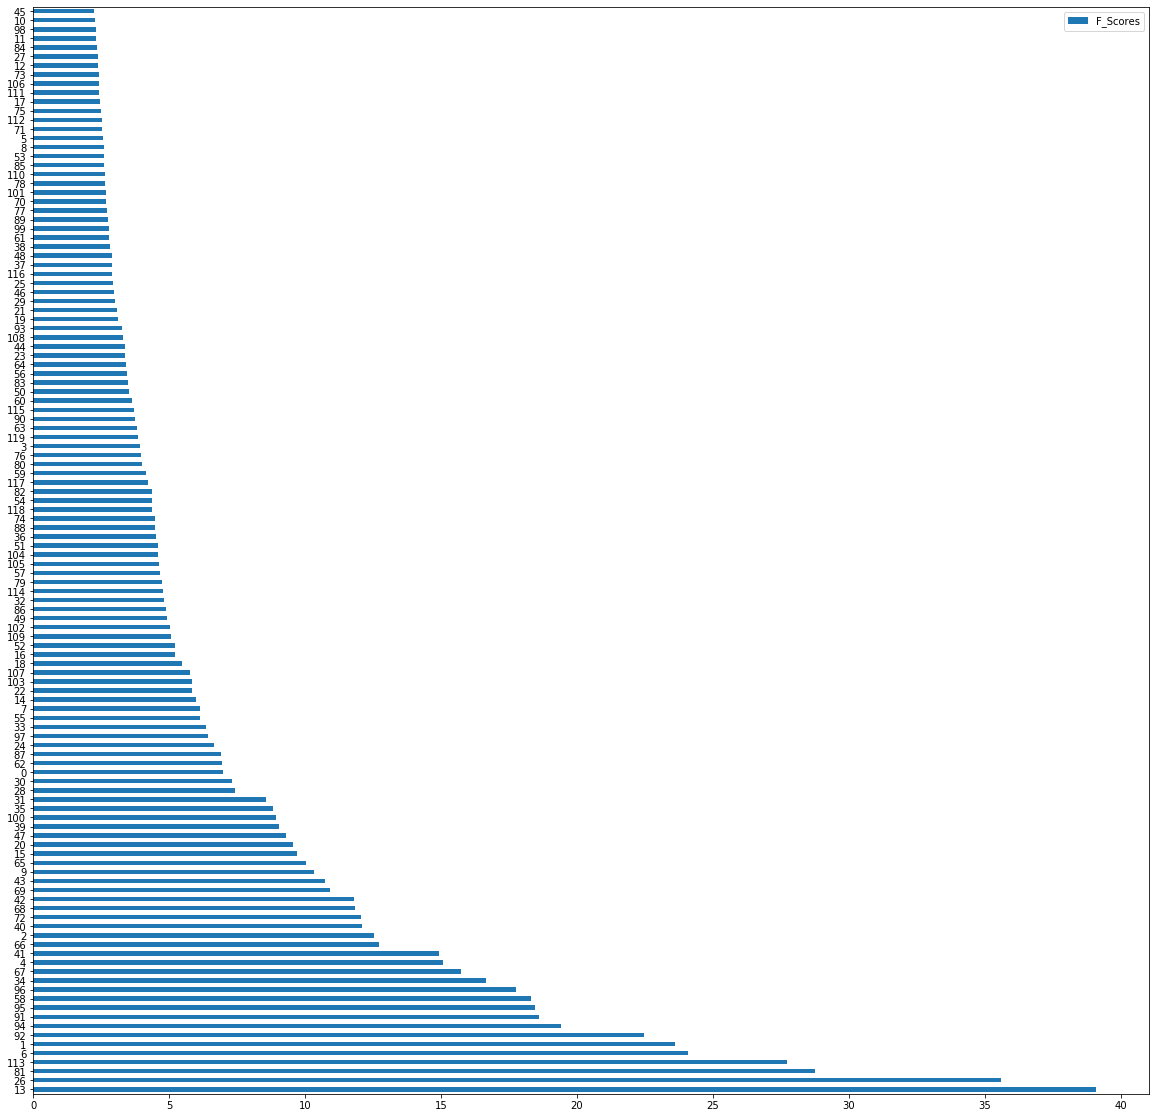

<Figure size 432x288 with 0 Axes>

In [106]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier

# using all data
x_all = data.iloc[:, :-1]
y_all = data.iloc[:, -1]

# rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
# selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1)
# k_features = selector.fit_transform(x_all.values, y_all.ravel())
# k_best_index = x_all.columns[selector.support_]
# k_best_names = x_all.columns.values[selector.support_]
# k_best_scores = selector.ranking_

# if not load_saved_data:
selector = SelectKBest(f_classif, k=k_best)
k_features = selector.fit_transform(x_all, y_all)
k_best_index = x_all.columns[selector.get_support()]
k_best_names = x_all.columns.values[selector.get_support()]
k_best_scores = selector.scores_[selector.get_support()]
k_best_names_scores = list(zip(k_best_names, k_best_scores))
ns_df = pd.DataFrame(data = k_best_names_scores, columns=['Feature', 'F_Scores'])
ns_df_sorted = ns_df.sort_values(['F_Scores', 'Feature'], ascending = [False, True])
ns_df_sorted.plot(kind='barh', figsize=(20, 20))
plt.show()
plt.savefig('shared/F_Scores.png')
    
#     with open('shared/k_best_index.pkl', 'wb') as filename:
#         pickle.dump(k_best_index.tolist(), filename)
# else:
#     with open('shared/k_best_index.pkl', 'rb') as pickle_file:
#         k_best_index = pickle.load(pickle_file)
#     k_best_index = pd.Index(k_best_index)

In [107]:
data_importance = data.loc[:, k_best_index]
data_importance.head()

,14,21,22,25,26,27,28,31,32,33,...,479,484,488,510,511,543,545,573,575,577
0,0.407019,0.242124,0.797675,0.647599,0.863698,0.398104,0.824561,0.732474,0.789717,0.407474,...,0.026741,0.496259,0.053242,0.143240,0.000000,0.325,0.338144,0.116901,0.150986,0.112244
1,0.519520,0.238978,0.712274,0.938169,0.981245,0.964903,0.878334,0.711244,0.803998,0.419772,...,0.020413,0.000000,0.194921,0.313269,0.000000,0.325,0.338144,0.093239,0.102807,0.068396
2,0.486824,0.238104,0.738940,0.948944,0.988650,0.989554,0.861788,0.749022,0.802593,0.370910,...,0.042200,0.000000,0.192235,0.533299,0.244275,0.325,0.338144,0.057042,0.077769,0.050771
3,0.491403,0.235237,0.724308,0.950029,0.976130,0.955045,0.807873,0.703792,0.804048,0.371762,...,0.055476,0.306714,0.000000,0.251524,0.000000,0.325,0.338144,0.050282,0.055956,0.043312
4,0.540562,0.234118,0.720752,0.931950,0.969992,0.949862,0.806589,0.681209,0.817460,0.375566,...,0.048339,0.463317,0.750039,0.327954,0.000000,0.325,0.338144,0.073099,0.090288,0.069148


## Generate m subsets of n features (least correlated to each other)

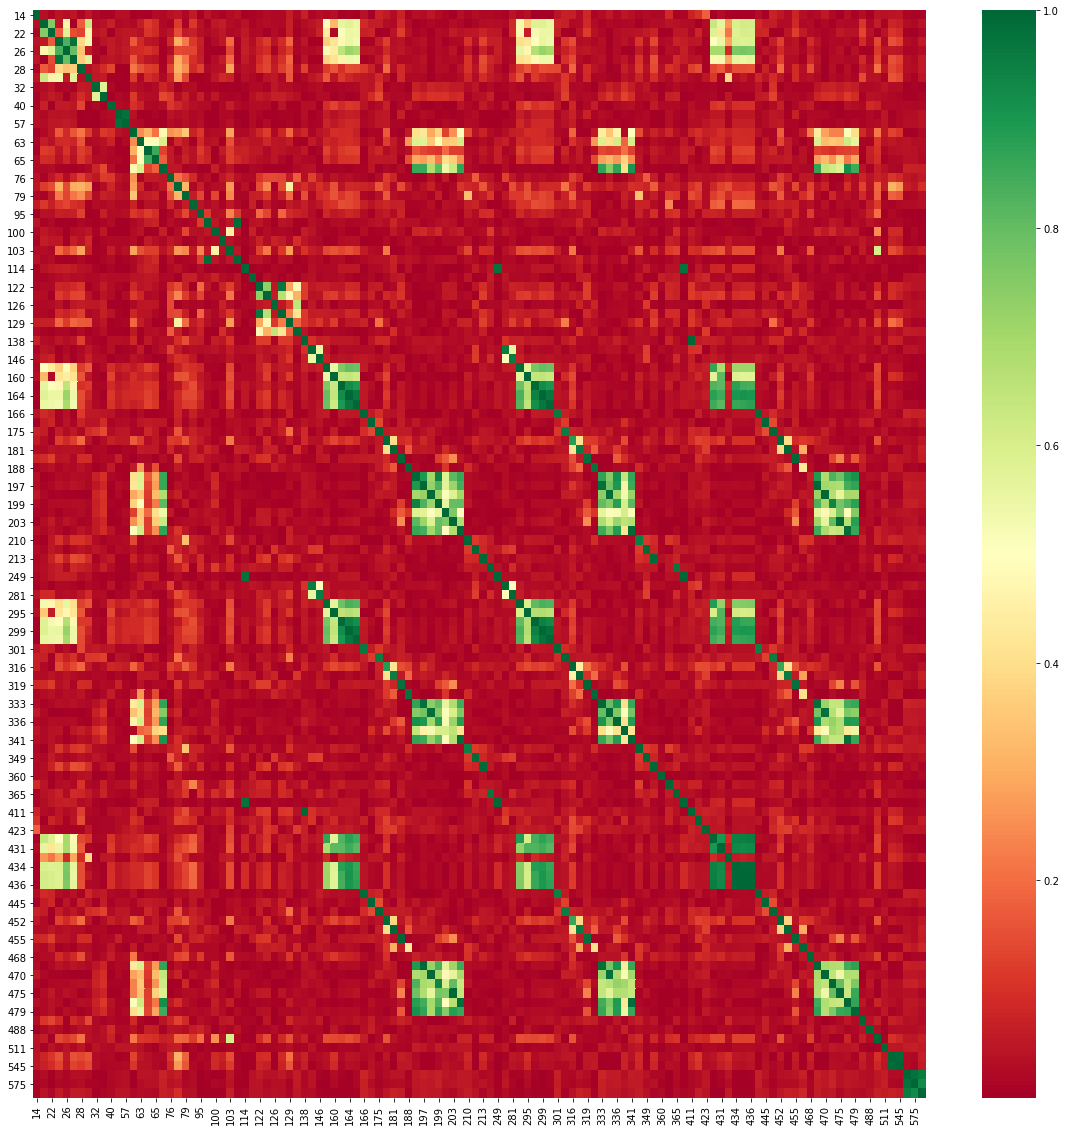

In [14]:
#get correlations of each features in dataset
corrmat = abs(data_importance.corr())
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(abs(data_importance[top_corr_features].corr()),annot=False,cmap="RdYlGn")
if not load_saved_data:
    plt.savefig('shared/P_Scores.png')

In [15]:
if not load_saved_data:
    problem = FCS(abs(corrmat.values), k_best, m_subsets)

    algorithm = GeneticAlgorithm(
            problem=problem,
            population_size=100,
            offspring_population_size=100,
            mutation=PermutationSwapMutation(1.0 / k_best),
            crossover=PMXCrossover(0.8),
            selection=BinaryTournamentSelection(),
            termination_criterion=StoppingByEvaluations(max=200000)
        )

    algorithm.observable.register(observer=PrintObjectivesObserver(10000))

    algorithm.run()
    result = algorithm.get_result()

    f = open('shared/fcs_ga_info.txt'.format(title), 'w')
    info = 'Algorithm: {}'.format(algorithm.get_name())
    info += 'Problem: {}'.format(problem.get_name())
    info += 'Solution: {}'.format(result.variables)
    info += 'Fitness: {}'.format(result.objectives[0])
    info += 'Computing time: {}'.format(algorithm.total_computing_time)
    print(info)
    f.write(info)

In [16]:
if not load_saved_data:
    features_allsubset = data.columns[result.variables]
    feature_subsets = []
    subset = []
    for i in features_allsubset:
        subset.append(str(i))
        if len(subset) == n_features:
            feature_subsets.append(subset)
            subset = []

    with open('shared/feature_subsets.pkl', 'wb') as filename:
        pickle.dump(feature_subsets, filename)
else:
    with open('shared/feature_subsets.pkl', 'rb') as pickle_file:
        feature_subsets = pickle.load(pickle_file)
        
print(feature_subsets)

[['107', '123', '39', '80', '59', '29', '31', '86', '116', '60', '130', '28', '37', '106', '11', '88', '77', '91', '131', '14', '17', '125', '66', '22', '113', '45', '87', '96', '10', '81', '0', '32', '117', '8', '101', '4', '23', '118', '7', '76'], ['25', '51', '75', '34', '99', '78', '103', '127', '83', '43', '33', '70', '2', '21', '53', '30', '102', '124', '68', '6', '79', '133', '94', '82', '128', '122', '92', '18', '71', '57', '27', '38', '104', '63', '19', '120', '100', '108', '89', '119'], ['55', '132', '50', '64', '84', '90', '65', '15', '61', '129', '1', '12', '47', '95', '35', '9', '67', '36', '46', '115', '105', '20', '126', '54', '114', '26', '24', '48', '16', '40', '44', '3', '58', '62', '74', '93', '98', '121', '41', '56']]


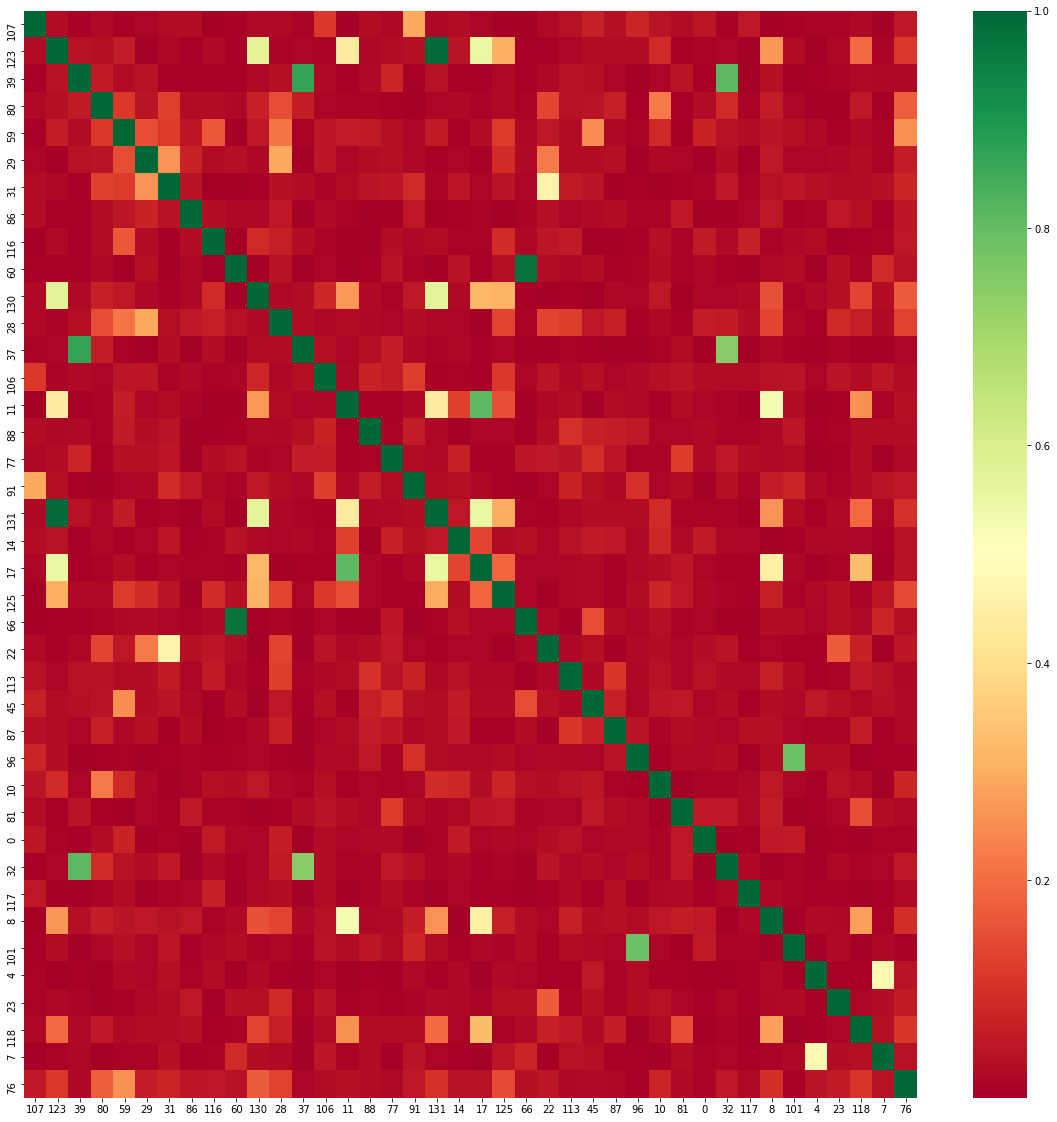

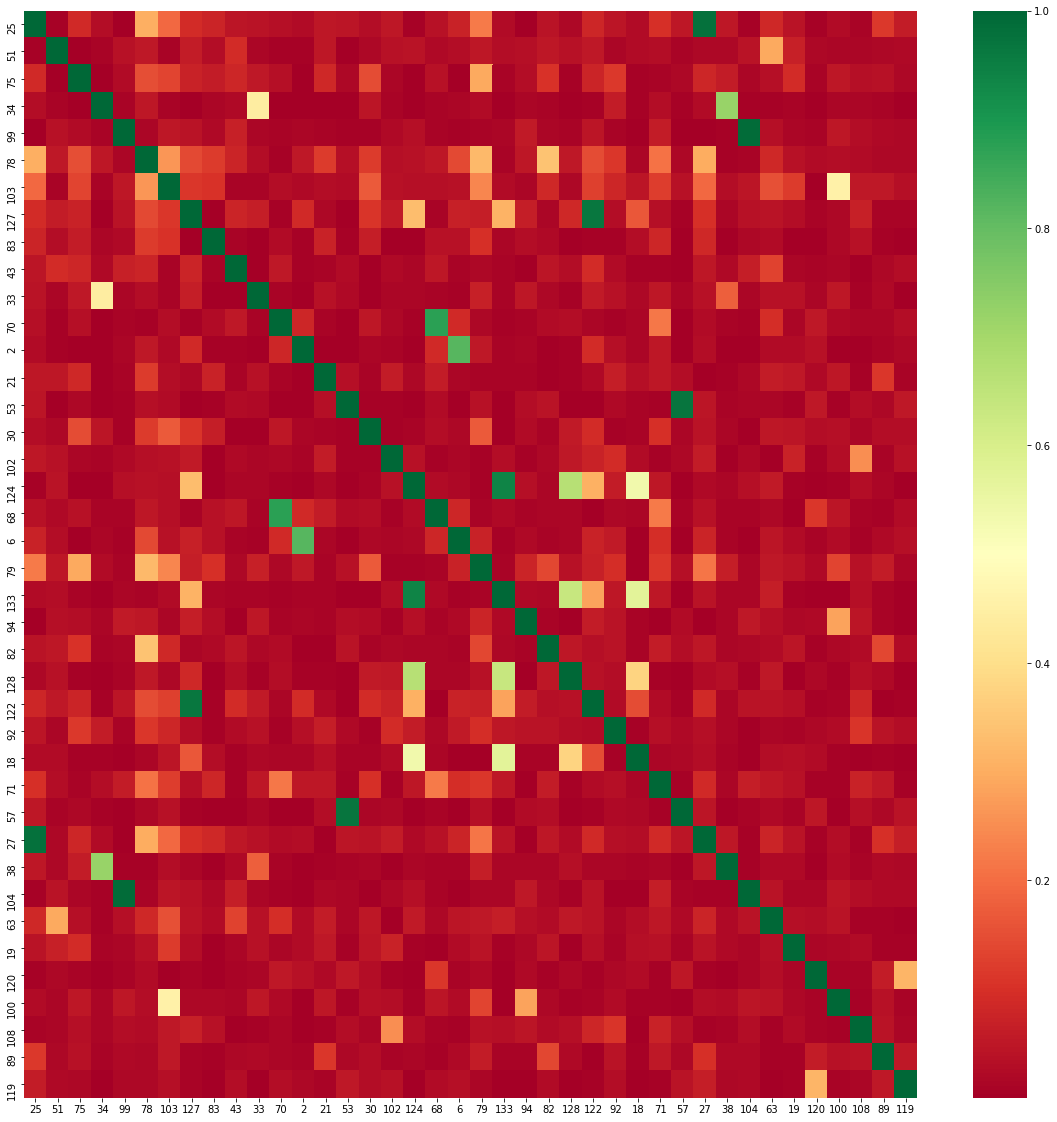

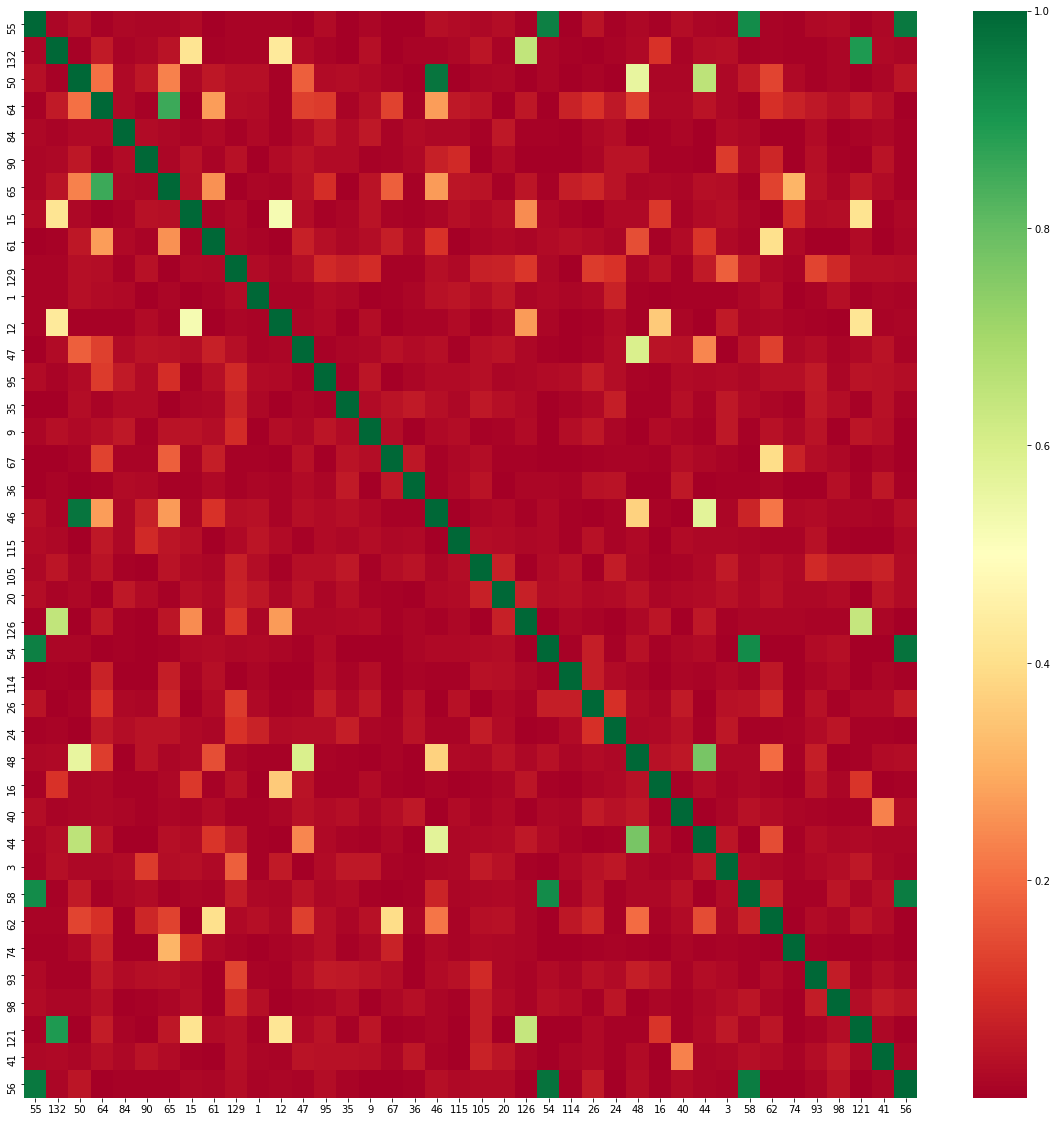

In [17]:
for subset_i in range(m_subsets):
    temp = data.loc[:, feature_subsets[subset_i]]
    corrmat = abs(temp.corr())
    top_corr_features = corrmat.index
    plt.figure(figsize=(20,20))
    #plot heat map
    g=sns.heatmap(abs(temp[top_corr_features].corr()),annot=False,cmap="RdYlGn")
    if not load_saved_data:
        plt.savefig('edge-m{}/P_Scores.png'.format(subset_i+1))

# Training & Test

In [137]:
from sklearn.svm import OneClassSVM
from keras import optimizers
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier

adam = optimizers.Adam(learning_rate=0.001)
sgd = optimizers.SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)

negative_pass = False
save_model = False
hid_neu = [32, 18, 32]

def test_model(clf, x_test_subset, y_test, title, title2):

    pass_no = -1 if negative_pass else 0
    
    print('Test on {}-{}'.format(title,title2))
    labels = ['Pass', 'Fail']
    # get the prediction on the test data
    # outlier labels (0 or 1)
    y_test_pred = clf.predict_classes(x_test_subset)
#     y_test_scores = clf.decision_function(x_test_subset)  # outlier scores
    
    if negative_pass:
        y_test.replace(0, -1, inplace = True)
    else:
        y_test.replace(-1, 0, inplace = True)
    
    print(y_test_pred)
    
    # Confusion matrix and classification report
    matrix = confusion_matrix(y_test, y_test_pred)
    g=sns.heatmap(matrix,annot=True,cbar=False, fmt='g', xticklabels=labels, yticklabels=labels)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion matrix of {}-{}'.format(title, title2))
    plt.savefig('{}/conmatrix-{}.png'.format(title, title2))
    plt.show()
    plt.close()
    
    counts = y_test.value_counts()
    print(counts)
    
    f = open('{}/info-{}.txt'.format(title, title2), 'w')
    info = 'Scenario : {}\n'.format(title)
    if title2 == 'test':
        info += 'Pass/Fail : {}/{}\n'.format(counts[pass_no], counts[1])
#         info += 'ROC-AUC score : {}\n'.format(roc_auc_score(y_test, y_test_scores))
    else:
        info += 'Pass : {}\n'.format(counts[pass_no])    
    info += classification_report(y_test, y_test_pred, target_names=labels)
    print(info)
    
    if save_model:
        f.write(info)

def train_model(x_train_subset, y_train, title):
    print('Train on {}'.format(title))
#     clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(x_train_subset, y_train)
#     clf = tree.DecisionTreeClassifier().fit(x_train_subset, y_train)
#     clf = svm.SVC(kernel='rbf').fit(x_train_subset, y_train)
#     clf = LogisticRegression(random_state=random_state).fit(x_train_subset, y_train)
#     clf = OneClassSVM(kernel='rbf', nu=fault_fraction, gamma='auto').fit(x_train_subset)
#     clf_name = 'AutoEncoder'
#     clf = AutoEncoder(epochs=200, hidden_neurons=hid_neu, contamination=fault_fraction, validation_size=0, random_state=random_state, verbose=2)
#     clf.fit(x_train_subset)

    clf = Sequential()
    clf.add(Dense(60, input_dim=x_train_subset.shape[1], activation='relu'))
    clf.add(Dense(30, activation='relu'))
    clf.add(Dense(1, activation='sigmoid'))
    clf.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    clf.fit(x_train_subset, y_train, epochs=100, batch_size=32)

    if save_model:
        with open('{}/autoencoder.h5'.format(title), 'wb') as f:
            dill.dump(clf, f, dill.HIGHEST_PROTOCOL)
    
    return clf

Test on cloud-k-test
[[1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]

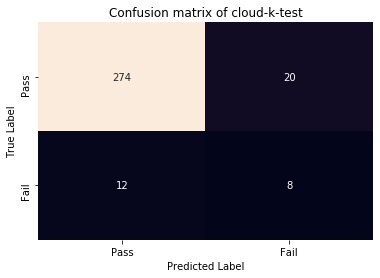

0.0    294
1.0     20
Name: Fault, dtype: int64
Scenario : cloud-k
Pass/Fail : 294/20
              precision    recall  f1-score   support

        Pass       0.96      0.93      0.94       294
        Fail       0.29      0.40      0.33        20

    accuracy                           0.90       314
   macro avg       0.62      0.67      0.64       314
weighted avg       0.92      0.90      0.91       314

Test on cloud-k-train
[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]


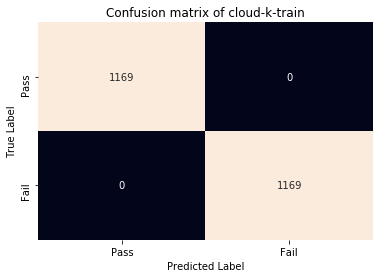

1.0    1169
0.0    1169
Name: Fault, dtype: int64
Scenario : cloud-k
Pass : 1169
              precision    recall  f1-score   support

        Pass       1.00      1.00      1.00      1169
        Fail       1.00      1.00      1.00      1169

    accuracy                           1.00      2338
   macro avg       1.00      1.00      1.00      2338
weighted avg       1.00      1.00      1.00      2338



In [138]:
test_model(clf, x_test_subset, y_test, title, 'test')
test_model(clf, x_train_subset, y_train, title, 'train')

In [132]:
from imblearn.over_sampling import SMOTE
from collections import Counter

x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.2, random_state=1)
sm = SMOTE(random_state=1)
x_train, y_train = sm.fit_resample(x_train, y_train)
print('Resampled dataset shape %s' % Counter(y_train))


# # Train on each edge
# for subset_i in range(m_subsets):
#     print(feature_subsets[subset_i])
#     x_train_subset = x_train.loc[:, feature_subsets[subset_i]]
#     x_test_subset = x_test.loc[:, feature_subsets[subset_i]]
#     title = 'edge-m{}'.format(subset_i+1)
#     clf = train_model(x_train_subset, title)
#     test_model(clf, x_test_subset, y_test, title)
#     test_model(clf, x_train_subset, y_train, title, 'train')

# Train on Cloud-k
x_train_subset = x_train.loc[:, k_best_index]
x_test_subset = x_test.loc[:, k_best_index]
title = 'cloud-k'
clf = train_model(x_train_subset, y_train, title)
test_model(clf, x_test_subset, y_test, title, 'test')
test_model(clf, x_train_subset, y_train, title, 'train')

# # Train on Cloud-all
# x_train_subset = x_train
# x_test_subset = x_test
# title = 'cloud-all'
# clf = train_model(x_train_subset, title)
# test_model(clf, x_test_subset, y_test, title)
# test_model(clf, x_train_subset, y_train, title, 'train')

Resampled dataset shape Counter({0.0: 1169, 1.0: 1169})
Train on cloud-k
Epoch 1/100
2338/2338 [==============================] - 1s 320us/step - loss: 0.6765 - accuracy: 0.5466
Epoch 2/100
2338/2338 [==============================] - 0s 102us/step - loss: 0.6498 - accuracy: 0.6334
Epoch 3/100
2338/2338 [==============================] - 0s 99us/step - loss: 0.6173 - accuracy: 0.6891
Epoch 4/100
2338/2338 [==============================] - 0s 94us/step - loss: 0.5685 - accuracy: 0.7224
Epoch 5/100
2338/2338 [==============================] - 0s 103us/step - loss: 0.5289 - accuracy: 0.7468
Epoch 6/100
2338/2338 [==============================] - 0s 100us/step - loss: 0.5103 - accuracy: 0.7545
Epoch 7/100
2338/2338 [==============================] - 0s 98us/step - loss: 0.4837 - accuracy: 0.7737
Epoch 8/100
2338/2338 [==============================] - 0s 93us/step - loss: 0.4716 - accuracy: 0.7849
Epoch 9/100
2338/2338 [==============================] - 0s 93us/step - loss: 0.4501 - accu

2338/2338 [==============================] - 0s 91us/step - loss: 0.0167 - accuracy: 0.9966
Epoch 78/100
2338/2338 [==============================] - 0s 95us/step - loss: 0.0144 - accuracy: 0.9987
Epoch 79/100
2338/2338 [==============================] - 0s 94us/step - loss: 0.0136 - accuracy: 0.9979
Epoch 80/100
2338/2338 [==============================] - 0s 94us/step - loss: 0.0144 - accuracy: 0.9983
Epoch 81/100
2338/2338 [==============================] - 0s 90us/step - loss: 0.0113 - accuracy: 0.9991
Epoch 82/100
2338/2338 [==============================] - 0s 90us/step - loss: 0.0127 - accuracy: 0.9996
Epoch 83/100
2338/2338 [==============================] - 0s 97us/step - loss: 0.0119 - accuracy: 0.9991
Epoch 84/100
2338/2338 [==============================] - 0s 89us/step - loss: 0.0165 - accuracy: 0.9970
Epoch 85/100
2338/2338 [==============================] - 0s 91us/step - loss: 0.0098 - accuracy: 0.9991
Epoch 86/100
2338/2338 [==============================] - 0s 99us/st

ValueError: Classification metrics can't handle a mix of binary and continuous targets

## ROC graph

In [ ]:
# subset0_y_test_pred = np.load('edge-m1/y_test_pred.npy')
# subset1_y_test_pred = np.load('edge-m2/y_test_pred.npy')
# subset2_y_test_pred = np.load('edge-m3/y_test_pred.npy')
# subset80_y_test_pred = np.load('subset80/y_test_pred.npy')
# subset90_y_test_pred = np.load('subset90/y_test_pred.npy')

# subset0_y_test_scores = np.load('edge-m1/y_test_scores.npy')
# subset1_y_test_scores = np.load('edge-m2/y_test_scores.npy')
# subset2_y_test_scores = np.load('edge-m3/y_test_scores.npy')
# subset80_y_test_scores = np.load('cloud-k/y_test_scores.npy')
# subset90_y_test_scores = np.load('cloud-all/y_test_scores.npy')

# fpr0, tpr0, thresholds0 = roc_curve(y_test, subset0_y_test_scores)
# fpr1, tpr1, thresholds1 = roc_curve(y_test, subset1_y_test_scores)
# fpr2, tpr2, thresholds2 = roc_curve(y_test, subset2_y_test_scores)
# fpr80, tpr80, thresholds80 = roc_curve(y_test, subset80_y_test_scores)
# fpr90, tpr90, thresholds90 = roc_curve(y_test, subset90_y_test_scores)

# plt.plot(fpr0, tpr0, label='ROC curve Edge-m1')
# plt.plot(fpr1, tpr1, label='ROC curve Edge-m2')
# plt.plot(fpr2, tpr2, label='ROC curve Edge-m3')
# plt.plot(fpr80, tpr80, label='ROC curve Cloud-k')
# plt.plot(fpr90, tpr90, label='ROC curve Cloud-all')
# plt.plot([0, 1], [0, 1], 'k--', label='Baseline')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve')
# plt.xlim([-0.02, 1])
# plt.ylim([0, 1.02])
# plt.legend(loc="lower right")
# plt.savefig('shared/roccurves.png')

# plt.plot(fpr80, tpr80, label='ROC curve Cloud-k')
# plt.plot(fpr90, tpr90, label='ROC curve Cloud-all')
# plt.plot([0, 1], [0, 1], 'k--', label='Baseline')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve')
# plt.xlim([-0.02, 1])
# plt.ylim([0, 1.02])
# plt.legend(loc="lower right")
# plt.savefig('shared/roccurves-cloud.png')

# plt.plot(fpr0, tpr0, label='ROC curve Edge-m1')
# plt.plot(fpr1, tpr1, label='ROC curve Edge-m2')
# plt.plot(fpr2, tpr2, label='ROC curve Edge-m3')
# plt.plot([0, 1], [0, 1], 'k--', label='Baseline')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve')
# plt.xlim([-0.02, 1])
# plt.ylim([0, 1.02])
# plt.legend(loc="lower right")
# plt.savefig('shared/roccurves-edge.png')

# Server-client code

In [ ]:
# # Server
# import socket
# import json
# import numpy as np
# import dill


# title = 'edge-m1/autoencoder.h5'
# with open(title, 'rb') as pickle_file:
#     clf = dill.load(pickle_file)

# host = '192.168.10.3'  # Server ip
# port = 4000
# s = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
# s.bind(('', port))

# print("Server Started")
# while True:
#     data, addr = s.recvfrom(1024)
#     data = json.loads(data.decode())
#     x_test_subset = np.array(data.get("msg"))
#     x_test_subset = np.array(x_test_subset).reshape(1, -1)
#     print("Message from: " + str(addr))
#     print("From connected user: ", len(x_test_subset))
#     y_test_pred = clf.predict(x_test_subset)
#     y_test_pred = np.array(y_test_pred).tolist()
#     message = json.dumps({"msg": y_test_pred})
#     s.sendto(message.encode(), addr)

In [ ]:
# # Client
# import datetime
# import socket
# import json
# import pickle
# import pandas as pd

# m_subsets = 3
# x_test = pd.read_pickle('shared/x_test.pkl')
# with open('shared/feature_subsets.pkl', 'rb') as pickle_file:
#     feature_subsets = pickle.load(pickle_file)
# with open('shared/k_best_index.pkl', 'rb') as pickle_file:
#     k_best_index = pickle.load(pickle_file)

# server = ('159.65.133.176', 4000)
# s = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
# s.connect(server)

# # Test on each edge
# # subset_i = 0
# # x_test_subset = x_test.loc[:, feature_subsets[subset_i]]

# # # Test on Cloud-k
# x_test_subset = x_test.loc[:, k_best_index]
# # # #
# # Test on Cloud-all
# # x_test_subset = x_test
# # #
# start = datetime.datetime.now()
# for x in x_test_subset.values:
#     x = x.tolist()
#     message = json.dumps({"msg": x})
#     print(message)
#     s.sendto(message.encode(), server)
#     data, addr = s.recvfrom(1024)
#     data = json.loads(data.decode())
#     y_test_pred = data.get("msg")
#     print("Received from server: ", y_test_pred)
# s.close()
# end = datetime.datetime.now()
# interval = end - start
# print(interval)